In [0]:
import numpy as np
import matplotlib.pyplot as plt
import scikitplot as skplt
from collections import Counter

import os
from os import path
from os.path import join

import keras
from keras.models import Sequential, Model, load_model
from keras.layers import Input, Conv1D, Conv2D, MaxPooling1D, MaxPooling2D, Dense, Dropout, Activation, Flatten, Reshape
from keras.layers.normalization import BatchNormalization
from keras.utils import to_categorical

import kapre
from kapre.time_frequency import Melspectrogram
from kapre.utils import Normalization2D

import librosa
from librosa import display

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import StratifiedShuffleSplit

### Training constants:

In [0]:
TEST_SET_SIZE = 0.25
BATCH_SIZE = 32
VALIDATION_SPLIT = 0.1
NUM_OF_EPOCHS = 15
VALIDATION_LOSS_PATIENCE = 5   # if validation accuracy doesn't improve in this number of
                               # epochs in a row, training stops 

### Assisting functions:

In [0]:
def fit_model(train_set, train_classes, history):
    # Using EarlyStopping will ensure we stop training if the validation accuracy doesn't improve.
    early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=VALIDATION_LOSS_PATIENCE)

    History = model.fit(train_set, train_classes, validation_split=VALIDATION_SPLIT, batch_size=BATCH_SIZE,
                        epochs=NUM_OF_EPOCHS, callbacks=[early_stop])

    # in order to append results of different data / data splits / epochs, over the same network
    if history is None:
        history = History.history
    else:
        for key in History.history.keys():
            history[key].extend(History.history[key])
    
    return history


def plot_training_curve(history):
    colors = {'loss':'r', 'acc':'b', 'val_loss':'m', 'val_acc':'g'}
    plt.figure(figsize=(10,6))
    plt.title("Training Curve") 
    plt.xlabel("Epoch")

    for measure in history.keys():
        color = colors[measure]
        num_of_samples = len(history[measure])
        plt.plot(range(1, num_of_samples + 1), history[measure], color + '-', label=measure)

    plt.legend(loc='upper left', scatterpoints=1, frameon=False)


def plot_results(test_set):
    # Plotting the accuracy score, confusion matrix and ROC curve
    test_prediction = model.predict_classes(test_set)
    test_probability = model.predict_proba(test_set)

    print("Accuracy score:", accuracy_score(test_classes, test_prediction),'\n')
    skplt.metrics.plot_confusion_matrix(test_classes, test_prediction, normalize=True)
    skplt.metrics.plot_roc(test_classes, test_probability)

### Load data:

In [0]:
# path = path.dirname(path.abspath(__name__))

path = "/content/drive/My Drive/Music Genre Classification"
AUDIO_PATH = join(path, 'data/genres')
classes_names = os.listdir(AUDIO_PATH)

data = [] 
classes = [] 
data_saved = None
savename = "3 seconds samples.npy"

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [0]:
if data_saved:    
    data = np.load("data - " + savename)
    classes = np.load("classes - " + savename)
    
else:
    for c in classes_names:
        for root, subdirs, files in os.walk(join(AUDIO_PATH, c)):
            for file in files:  
                for i in range(0, 30, 3):
                    file_path = join(root, file)    
                    wavedata, samplerate = librosa.load(file_path, sr=None, mono=True, offset=i, duration=2)    
                    wavedata = wavedata[np.newaxis, :]
                    data.append(wavedata)
                    classes.append(c)
    # np.save("data - " + savename, data)
    # np.save("classes - " + savename, classes)
    # data_saved = True

data = np.array(data)
print(data.shape)

(10000, 1, 44100)


### Set result vectors (final layer wanted values):

In [0]:
label_encoder = LabelEncoder()
label_encoder.fit(classes)

num_of_classes = len(label_encoder.classes_)
print(num_of_classes, "classes:", ", ".join(list(label_encoder.classes_)))

classes_as_numbers = label_encoder.transform(classes)
classes_1_hot = to_categorical(classes_as_numbers)
print("\nclasses' vectors:\n", classes_1_hot)

10 classes: blues, classical, country, disco, hiphop, jazz, metal, pop, reggae, rock

classes' vectors:
 [[0. 0. 1. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]


### Split data to train set and test set:

In [0]:
splitter = StratifiedShuffleSplit(n_splits=1, test_size=TEST_SET_SIZE)
splits = splitter.split(data, classes_as_numbers)

for train_index, test_index in splits:
    print("TRAIN INDEX:", train_index)
    print("TEST INDEX:", test_index)
    
    train_set = data[train_index]
    test_set = data[test_index]
    
    train_classes = classes_as_numbers[train_index]
    train_classes_1_hot = classes_1_hot[train_index]
    test_classes = classes_as_numbers[test_index]

input_shape = train_set.shape[1:]
print(train_set.shape)
print(test_set.shape)
print(input_shape)

TRAIN INDEX: [7817 3775 6938 ...  593 8210 9148]
TEST INDEX: [ 743 1048 3194 ... 9858 1745 4105]
(7500, 1, 44100)
(2500, 1, 44100)
(1, 44100)


### This use of split makes sure that there is an equal amount of instances in each class.

In [0]:
count = Counter(train_classes)
print("Number of files in each category in train set:")
for k in sorted(count.keys()):
    print(k, ":", count[k])

Number of files in each category in train set:
0 : 750
1 : 750
2 : 750
3 : 750
4 : 750
5 : 750
6 : 750
7 : 750
8 : 750
9 : 750


# Using a 1-dimension convolution model.

Since audio can be represented as a TIME SERIES, the convolution that should fit the data properly is 1 dimesional (scanning left to right - on a "time" axis, as oppose to scanning the Y axis as well).

CNNs work best on images. Our first network uses raw data to learn (audio), and indeed the results are no good.

In [0]:
# Load saved model option (skip if first time running)

# model = keras.models.load_model("conv1d.h5", custom_objects={'Melspectrogram':kapre.time_frequency.Melspectrogram, 
                                                                       'Normalization2D': kapre.utils.Normalization2D})
# history = np.load(modelName + "-history.npy").item()

In [0]:
modelName = "conv1d"
np.random.seed(0)

model = Sequential()

# Old - starting with 1000 neurons and extracting features from them
# directly (no training of on them). Then, using a convolution on them.
# model.add(Dense(1000, input_shape=input_shape, activation='relu'))

# Convolution in 1D and shortening result vector x4 (max pooling)
model.add(Conv1D(filters=32, kernel_size=8, input_shape=(input_shape[1], 1), activation='relu'))

# model.add(Conv1D(32, 8, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=4)) 

# Second convolution to find more "sophisticated" features
model.add(Conv1D(32, 8, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=4)) 

model.add(Flatten())
model.add(Dense(100, activation='relu')) 
model.add(BatchNormalization())
model.add(Dense(num_of_classes, activation='softmax'))

# Optimizing with adam here can give slightly better results than SGD (still not really good). Takes very long time.
# adam = keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)

model.compile(loss='categorical_crossentropy' , optimizer='sgd' , metrics=['accuracy'])

history = None
    
model.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_21 (Conv1D)           (None, 44093, 32)         288       
_________________________________________________________________
batch_normalization_7 (Batch (None, 44093, 32)         128       
_________________________________________________________________
max_pooling1d_21 (MaxPooling (None, 11023, 32)         0         
_________________________________________________________________
conv1d_22 (Conv1D)           (None, 11016, 32)         8224      
_________________________________________________________________
batch_normalization_8 (Batch (None, 11016, 32)         128       
_________________________________________________________________
max_pooling1d_22 (MaxPooling (None, 2754, 32)          0         
_________________________________________________________________
flatten_12 (Flatten)         (None, 88128)           

In [0]:
# Save model option

# model.save(modelName + ".h5")
# np.save(modelName + "-history.npy", history)

 ### Fit model to data:

In [0]:
train_set_1_channel = train_set.reshape(-1, train_set.shape[2], 1)
test_set_1_channel = test_set.reshape(-1, test_set.shape[2], 1)

history = fit_model(train_set_1_channel, train_classes_1_hot, history)
plot_training_curve(history)

Train on 6750 samples, validate on 750 samples
Epoch 1/15
 960/6750 [===>..........................] - ETA: 7:38 - loss: 2.1819 - acc: 0.2542

## Results:

In [0]:
plot_results(test_set_1_channel)

# Using KAPRE's Melspectrogram.

The input layer is Mel-Spectrogram. It's a way to pre-process the data before it enters the network. It applies a discrete Fourier transform on the samples (giving the most relevant frequencies for each sample).
It uses the Mel scale of the frequencies (a logarithmic representation of the frequencies, giving a linear representaion of how HUMANS perceive differences in sound).
The Mel scale is then used to filter out low frequencies of the initial Fourier transformation (the frequencies that are more relevant to us - where most changes happen), and the results of all adjacent samples are shown as a spectrogram.
The final step is a discrete cosine transform, used to decorrelate the adjacent samples. This results in the relevant spectrograms and creates new features right from the beginning. Such features are easier to work with and give more relevant information and prediction power.

IMPORTANT - For the network to consider the Melspectrogram as its input, we must set the 'trainable' parameter of this layer to False. Otherwise different parts of the raw data itself will get different weights when converted to a spectrogram (while all parts should be converted equally). Trying to train those weights as well gave a validation accuracy of lower than 0.6 in all tests.

### A Mel spectrogram looks as follows:

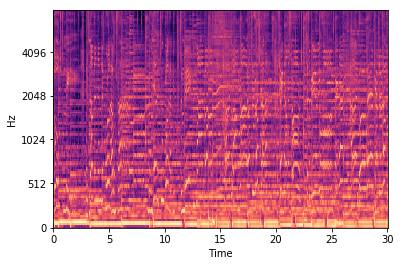

In [0]:
# Melspectrogram of the first audio file in the data

audio_files_path = join(AUDIO_PATH, classes_names[0])
audio_files = os.walk(audio_files_path).__next__()[2]
audio_file_path = join(audio_files_path, audio_files[0])

y, sr = librosa.load(audio_file_path)
S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128, fmax=8000)
display.specshow(librosa.power_to_db(S, ref=np.max), y_axis='mel', fmax=8000, x_axis='time')
plt.show()

In [0]:
# Load saved model option (skip if first time running)

# model = keras.models.load_model("conv1d_MelSpec.h5", custom_objects={'Melspectrogram':kapre.time_frequency.Melspectrogram, 
                                                                       'Normalization2D': kapre.utils.Normalization2D})
# history = np.load(modelName + "-history.npy").item()

### Following is the convolution1D model using a spectrogram image.
(This is the model that predicted the best)

In [0]:
modelName = "conv1d_MelSpec"
np.random.seed(0)

model = Sequential()

# Initial layer treated as input
model.add(Melspectrogram(n_dft=1024, n_hop=512, input_shape=input_shape, return_decibel_melgram=True,
                         name='melgram', trainable=False))
model.add(Normalization2D(str_axis='freq'))
model.add(Reshape((-1, 1)))

# Convolution in 1D and shortening result vector x4 (max pooling)
model.add(Conv1D(filters=32, kernel_size=8, activation='relu'))
# model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=4)) 

# Second convolution to find more "sophisticated" features
model.add(Conv1D(filters=32, kernel_size=8, activation='relu'))
# model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=4)) 
model.add(Flatten()) 

model.add(Dense(100, activation='relu')) 
#model.add(BatchNormalization())
model.add(Dense(num_of_classes, activation='softmax'))

# Optimizing with SGD such that song makes a correction (ok to use since data is shuffled).
# Learning is faster and we avoid shallow local minima more easily.
model.compile(loss='categorical_crossentropy' , optimizer='sgd' , metrics=['accuracy'])

history = None
    
model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
melgram (Melspectrogram)     (None, 128, 87, 1)        0         
_________________________________________________________________
normalization2d_8 (Normaliza (None, 128, 87, 1)        0         
_________________________________________________________________
reshape_8 (Reshape)          (None, 11136, 1)          0         
_________________________________________________________________
conv1d_19 (Conv1D)           (None, 11129, 32)         288       
_________________________________________________________________
max_pooling1d_19 (MaxPooling (None, 2782, 32)          0         
_________________________________________________________________
conv1d_20 (Conv1D)           (None, 2775, 32)          8224      
_________________________________________________________________
max_pooling1d_20 (MaxPooling (None, 693, 32)         

In [0]:
# Save model option

# model.save(modelName + ".h5")
# np.save(modelName + "-history.npy", history)

 ### Fit model to data:

Train on 6750 samples, validate on 750 samples
Epoch 1/15
6750/6750 [==============================] - 123s 18ms/step - loss: 1.6509 - acc: 0.4136 - val_loss: 1.4243 - val_acc: 0.4747
Epoch 2/15
6750/6750 [==============================] - 123s 18ms/step - loss: 1.2296 - acc: 0.5713 - val_loss: 1.1659 - val_acc: 0.5707
Epoch 3/15
6750/6750 [==============================] - 122s 18ms/step - loss: 1.0369 - acc: 0.6385 - val_loss: 1.0095 - val_acc: 0.6520
Epoch 4/15
6750/6750 [==============================] - 122s 18ms/step - loss: 0.9232 - acc: 0.6784 - val_loss: 0.9134 - val_acc: 0.6813
Epoch 5/15
6750/6750 [==============================] - 123s 18ms/step - loss: 0.8360 - acc: 0.7124 - val_loss: 0.9997 - val_acc: 0.6627
Epoch 6/15
6750/6750 [==============================] - 122s 18ms/step - loss: 0.7393 - acc: 0.7467 - val_loss: 0.8125 - val_acc: 0.7173
Epoch 7/15
6750/6750 [==============================] - 122s 18ms/step - loss: 0.6363 - acc: 0.7791 - val_loss: 0.8063 - val_acc: 0

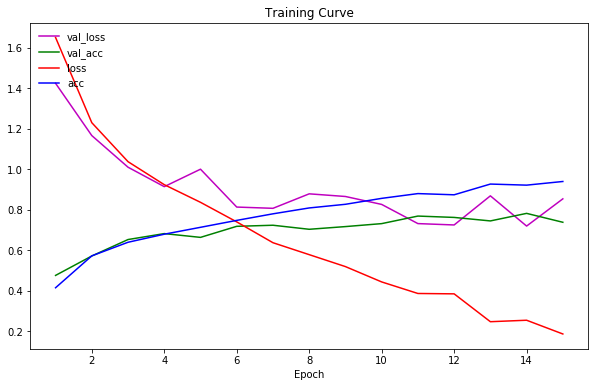

In [0]:
history = fit_model(train_set, train_classes_1_hot, history)
plot_training_curve(history)

## Results:

Accuracy score: 0.7832 



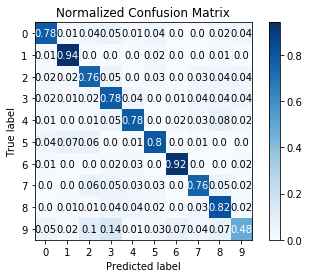

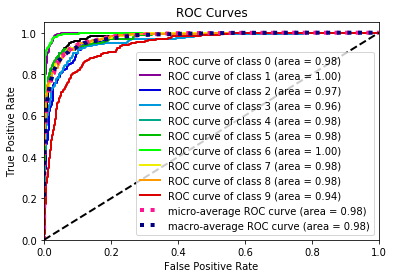

In [0]:
plot_results(test_set)

# Next CNN uses a 2-dimension convolution model.

Since we're working with an image input now, a 2D convolution should be helpful.
But as mentioned before, the spectrogram represents a times series, and looking for features in both dimensions might be redundant. Indeed, the same network with a 2D convolution, instead of 1D, gave a slightly less accurate result.

In [0]:
# Load saved model option (skip if first time running)

# model = keras.models.load_model("conv2d_MelSpec.h5", custom_objects={'Melspectrogram':kapre.time_frequency.Melspectrogram, 
                                                                       'Normalization2D': kapre.utils.Normalization2D})
# history = np.load(modelName + "-history.npy").item()

In [0]:
modelName = "conv2d_MelSpec"
np.random.seed(0)

model = Sequential()
model.add(Melspectrogram(n_dft=1024, n_hop=512, input_shape=input_shape, return_decibel_melgram=True, name='melgram', trainable=False))
model.add(Normalization2D(str_axis='freq'))

model.add(Conv2D(32, (3, 3), activation='relu'))
#model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2))) 

model.add(Conv2D(32, (3, 3), activation='relu'))
#model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2))) 
model.add(Flatten()) 

model.add(Dense(100, activation='relu')) 
# model.add(BatchNormalization())
model.add(Dense(num_of_classes,activation='softmax'))

model.compile(loss='categorical_crossentropy' , optimizer='sgd' , metrics=['accuracy'])

history = None
    
model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
melgram (Melspectrogram)     (None, 128, 87, 1)        0         
_________________________________________________________________
normalization2d_9 (Normaliza (None, 128, 87, 1)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 126, 85, 32)       320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 63, 42, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 61, 40, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 30, 20, 32)        0         
_________________________________________________________________
flatten_11 (Flatten)         (None, 19200)           

In [0]:
# Save model option

# model.save(modelName + ".h5")
# np.save(modelName + "-history.npy", history)

 ### Fit model to data:

Train on 6750 samples, validate on 750 samples
Epoch 1/15
6750/6750 [==============================] - 120s 18ms/step - loss: 1.8277 - acc: 0.3499 - val_loss: 1.6481 - val_acc: 0.4133
Epoch 2/15
6750/6750 [==============================] - 119s 18ms/step - loss: 1.4761 - acc: 0.4803 - val_loss: 1.4231 - val_acc: 0.5040
Epoch 3/15
6750/6750 [==============================] - 118s 17ms/step - loss: 1.2706 - acc: 0.5670 - val_loss: 1.2332 - val_acc: 0.5680
Epoch 4/15
6750/6750 [==============================] - 117s 17ms/step - loss: 1.0946 - acc: 0.6210 - val_loss: 1.0858 - val_acc: 0.6067
Epoch 5/15
6750/6750 [==============================] - 117s 17ms/step - loss: 0.9585 - acc: 0.6656 - val_loss: 1.1300 - val_acc: 0.5947
Epoch 6/15
6750/6750 [==============================] - 117s 17ms/step - loss: 0.8550 - acc: 0.7041 - val_loss: 0.9934 - val_acc: 0.6520
Epoch 7/15
6750/6750 [==============================] - 117s 17ms/step - loss: 0.7451 - acc: 0.7384 - val_loss: 1.0687 - val_acc: 0

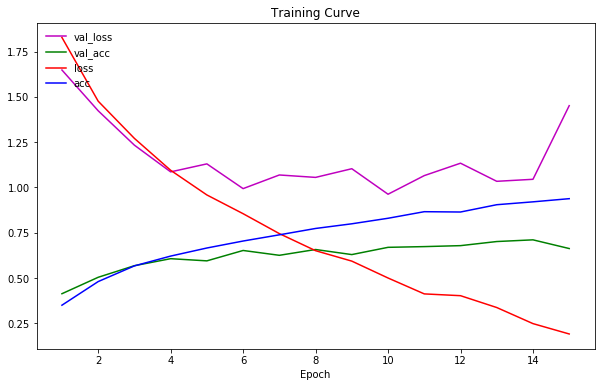

In [0]:
history = fit_model(train_set, train_classes_1_hot, history)
plot_training_curve(history)

## Results:

Accuracy score: 0.6568 



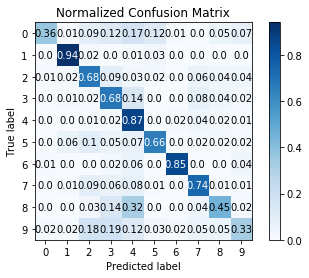

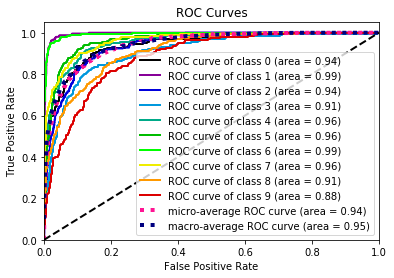

In [0]:
plot_results(test_set)